<a href="https://colab.research.google.com/github/Abstract-code-ops/ML-from-scratch/blob/main/decisionTreeScratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision Trees

Decision trees are machine learning algorithms used for classification and regression with mainly tabular data. Now a days decision trees are not much used however there are more sophisticated algorithms that are built on basic decision trees such as random trees and boosted trees.

If you are familliar with working on linked lists and tree search algorithms you might have an easier time understanding what decision trees do. A decision tree predicts a class or value of target by learning simple decision rules inferred from prior data.

They split a dataset into different side of thresholds and repeat the process in each branch which yield a flowchart like tree where a condition is evaluated before travesing a specific branch

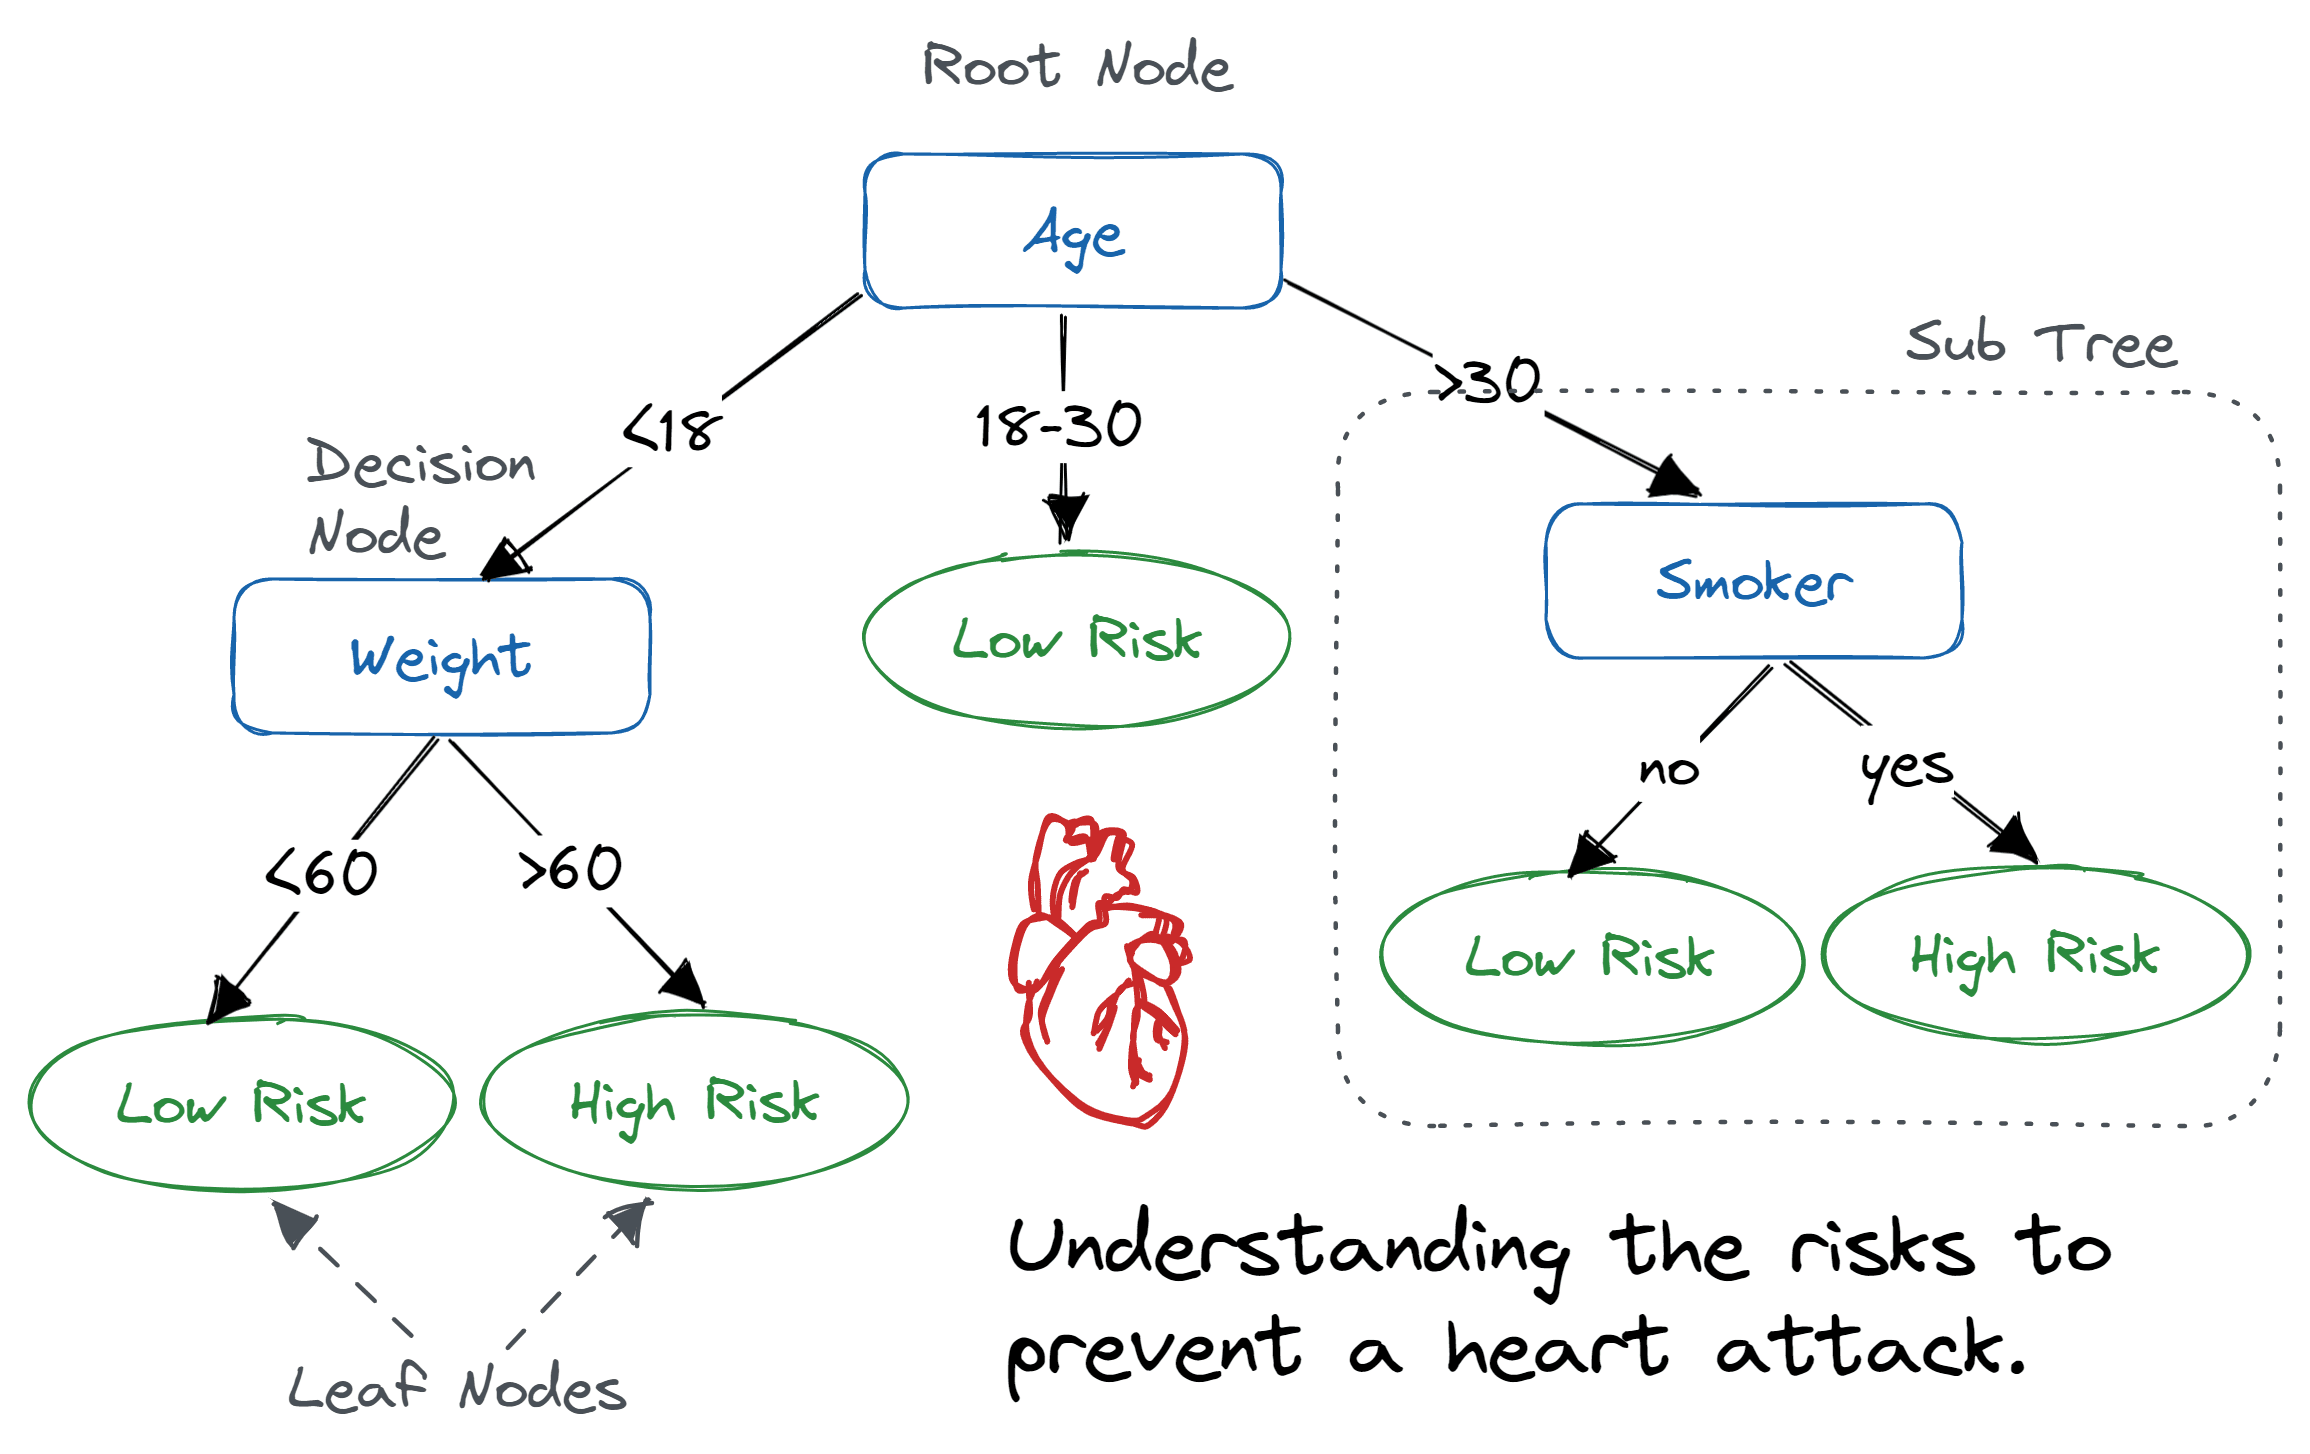



# Implementation from scratch

In [ ]:
import numpy as np
from collections import Counter
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [ ]:
class Node:
  def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
    self.feature = feature
    self.threshold = threshold
    self.left = left
    self.right = right
    self.value = value

  def is_leaf_node(self):
    return self.value is not None

In [ ]:
class DecisionTree:
  def __init__(self, min_samples_split=2, max_depth=100, n_features=None):
    self.min_samples_split = min_samples_split #split a specific node in 2 (should actually fix it to just 2 here...)
    self.max_depth = max_depth # max depth of tree
    self.n_features = n_features
    self.root= None

  def fit(self, X, y):
    self.n_features = X.shape[1] if not self.n_features else min(X.shape[1], self.n_features) #check if n_features does not exceed the number of total features available
    self.root = self._grow_tree(X, y) # helper function to expand tree from the root node

  def _grow_tree(self, X, y, depth=0):
    n_samples, n_features = X.shape
    n_labels = len(np.unique(y)) #no of classes

    if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split): # see if we've reached a leaf node and return it (stops at max depth or if cannot split node to 2)
      leaf_value = self._label_count(y) #classify this leaf node as the class that occurs most frequently in it's side of the split, helper function is used for that although you can just code it here
      return Node(value=leaf_value)

    featuresIdx = np.random.choice(n_features, self.n_features, replace=False) #select random features to split by. The randomness also introduces bias

    best_feature, best_thresh = self._best_split(X, y, featuresIdx) # select the best feature from the random features picked and select the best threshold to split that feature by, helper function used

    left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh) # split the selected feature by the threshold

    left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth+1)       # grow tree on the left and right if this reminds you of recursion that's
    right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth+1)    # exactly what it's doing and it's base case is the leaf node check above

    return Node(best_feature, best_thresh, left, right) # so now it becomes something like a linked list more or less.

  def _best_split(self, X, y, featuresIdx):
    """
    this funtion uses entropy and information gain to see the best feature and threshold to split the decision boundary by
    returns the index of the feature and threshold
    """
    best_gain = -1
    split_idx, split_thresh = None, None

    for feature_idx in featuresIdx:
      x_column = X[:, feature_idx]
      thresholds = np.unique(x_column)

      for thr in thresholds:
        gain = self._info_gain(x_column, y, thr) # helper function to calculate information gain using entropy

        if gain > best_gain:
          best_gain = gain
          split_idx = feature_idx
          split_thresh = thr
    return split_idx, split_thresh

  def _info_gain(self, x_column, y, threshold):
    parent_entropy = self._entropy(y) # helper funtion calculates entropy

    left_idxs, right_idxs = self._split(x_column, threshold) # does a split by the feature and threshold passed

    if len(left_idxs) == 0 or len(right_idxs) == 0:
      return 0

    n = len(y)
    n_l, n_r = len(left_idxs), len(right_idxs)
    e_l, e_r = self._entropy(y[left_idxs]), self._entropy(y[right_idxs]) # calculate entropy on the 2 splits
    child_entropy = (n_l/n) * e_l + (n_r/n) * e_r # combine them

    ig = parent_entropy - child_entropy # this is how you get information gain by substracting the parent from the child entropy
    return ig

  def _split(self, x_column, threshold):
    left_idxs = np.argwhere(x_column <= threshold).flatten()
    right_idxs = np.argwhere(x_column > threshold).flatten()
    return left_idxs, right_idxs

  def _entropy(self, y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log(p) for p in ps if p > 0])

  def _label_count(self, y):
    counter = Counter(y)
    return counter.most_common(1)[0][0]

  def _traverse_tree(self, x, node):
    if node.is_leaf_node():
      return node.value
    if x[node.feature] <= node.threshold:
      return self._traverse_tree(x, node.left)
    return self._traverse_tree(x, node.right)

  def predict(self, X):
    return np.array([self._traverse_tree(x, self.root) for x in X])


In [ ]:
data = datasets.load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = DecisionTree(max_depth=10)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
train_predictions = clf.predict(X_train)

def accuracy(y_test, y_pred):
  return np.sum(y_test == y_pred) / len(y_test)

print(f"{accuracy(y_test, predictions).item()*100}%")
print(f"{accuracy(y_train, train_predictions).item()*100}%")

93.85964912280701%
100.0%
